In [7]:
from datetime import datetime
from datetime import timedelta
import shapefile
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from pymongo import MongoClient
%matplotlib inline

In [8]:
tree = ET.parse('/media/amassaro/external_2T/telecom_bigdata_2015/data/external_data/xml_incidenti_mar-apr_2015.xml')
root=tree.getroot()
child=list(root)[1]

In [9]:
time=[]
for j in child:
    if 'DataOraIncidente' in j.attrib.keys():
        time.append(j.attrib['DataOraIncidente'])

time=np.array([t[:10]+' '+t[11:] for t in time])
time=np.array([datetime.strptime(t,'%Y-%m-%d %H:%M:%S') for t in time])
day_time_comune=np.array([[t.weekday()+1,t.hour] for t in time])

In [10]:
db=MongoClient()
db=db['call_out_roma']
cur=db['callOut'].find()
total_calls_in={}
times=db['callOut'].distinct('time_interval')
for t in times:
    total_calls_in[t]=0
for c in cur:
    total_calls_in[c['time_interval']]+=c['n_of_calls']
total_calls_in_d={}
keys_orig=total_calls_in.keys()
keys=[datetime.fromtimestamp(t) for t in keys_orig]
for i in range(len(keys_orig)):
    total_calls_in_d[keys[i]]=total_calls_in[keys_orig[i]]
total_calls_in=total_calls_in_d

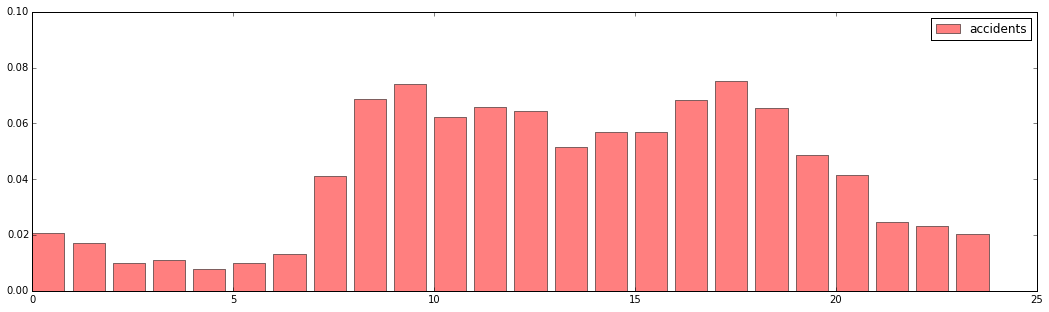

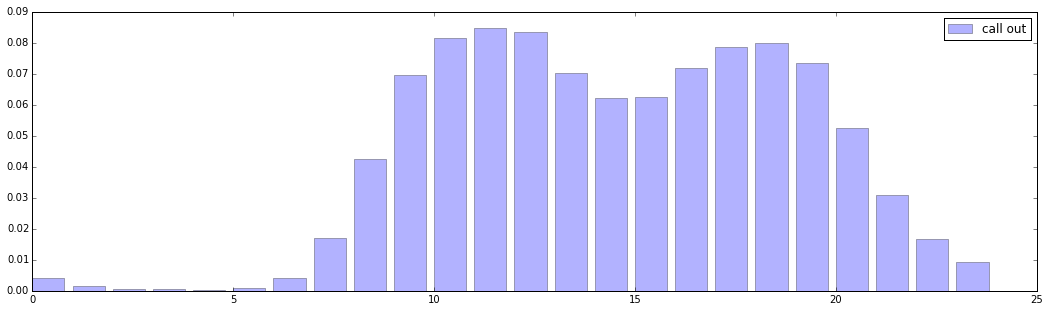

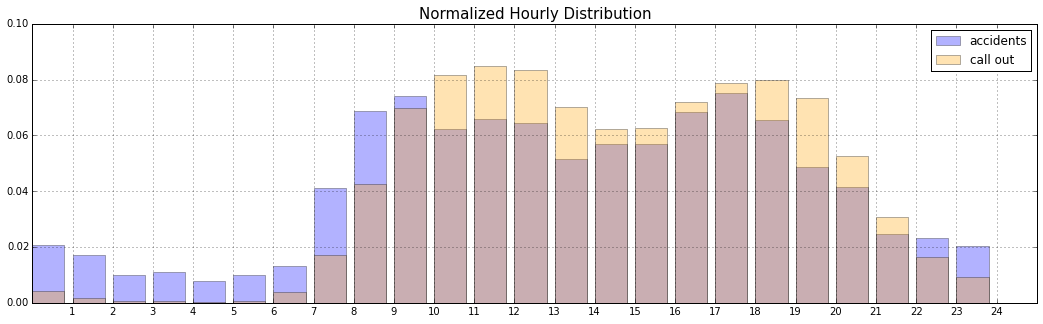

In [5]:
#plt.hist(day_time_comune[:,1],normed=True,bins=list(range(25)),alpha=0.5,color='black',label='incidenti')
H=np.histogram(day_time_comune[:,1],normed=True,bins=list(range(25)))
plt.bar(H[1][:-1],H[0],alpha=0.5,color='red',label='accidents')
plt.legend(loc='upper right')
plt.ylim([0,.1])
plt.gcf().set_size_inches(18, 5)
plt.show()

heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.hour==i]) for i in range(24)])
heights=heights/sum(heights)
plt.bar(list(range(24)),heights,alpha=0.3,label='call out')
plt.gcf().set_size_inches(18, 5)
plt.legend(loc='upper right')
plt.show()

heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.hour==i]) for i in range(24)])
heights=heights/sum(heights)
plt.bar(H[1][:-1],H[0],alpha=0.3,color='blue',label='accidents')
plt.bar(list(range(24)),heights,alpha=0.3,color='orange',label='call out')
plt.xticks([i for i in range(1,25)])
plt.title('Normalized Hourly Distribution',size=15)
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_size_inches(18, 5)
plt.ylim([0,.1])
plt.show()





In [ ]:
H=np.histogram(day_time_comune[:,0],normed=True,bins=list(range(1,9)))
plt.bar(H[1][:-1],H[0],alpha=0.3,color='black',label='incidenti')
#plt.hist(day_time_comune[:,0],normed=True,bins=list(range(1,9)),alpha=0.5,color='black',label='incidenti')
plt.legend(loc='upper right')
plt.ylim([0,.18])
plt.gcf().set_size_inches(18, 5)
plt.show()

plt.bar(list(range(1,8)),[sum([total_calls_in[x] for x in total_calls_in.keys() if x.weekday()==i]) for i in range(7)],alpha=0.3,color='blue',label='call in')
plt.gcf().set_size_inches(18, 5)
plt.legend(loc='upper right')
plt.show()

heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.weekday()==i]) for i in range(7)])
heights=heights/sum(heights)

plt.bar(H[1][:-1],H[0],alpha=0.3,color='blue',label='accidents')
plt.bar(list(range(1,8)),heights,alpha=0.3,color='orange',label='call out')
plt.gcf().set_size_inches(18, 5)
plt.xticks([1,2,3,4,5,6,7],['mon','tue','wed','thu','wed','sat','sun'])
plt.title('Daily Probability')
plt.legend(loc='upper right')
plt.show()

mon


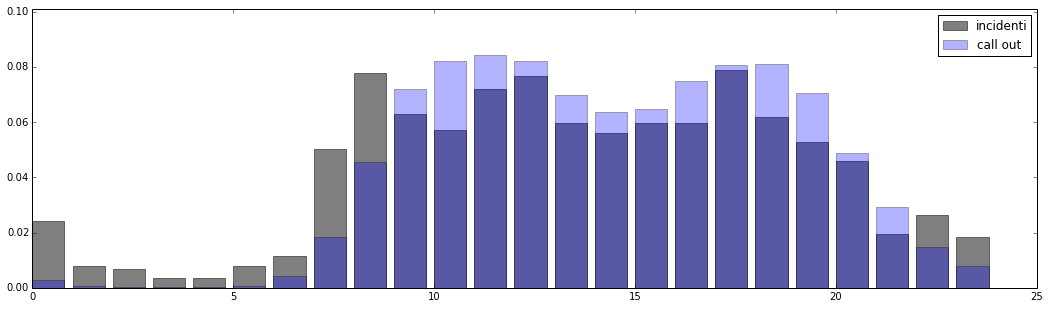

tue


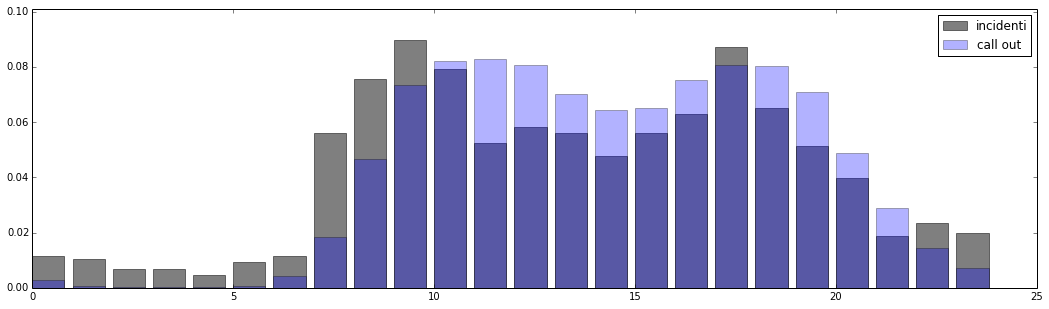

wed


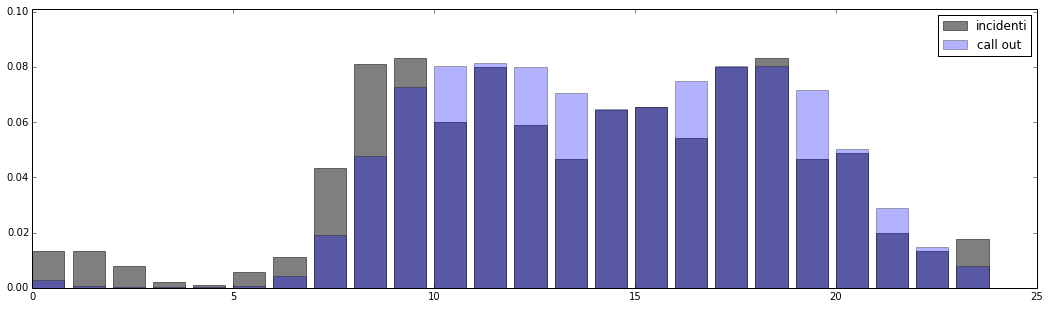

thu


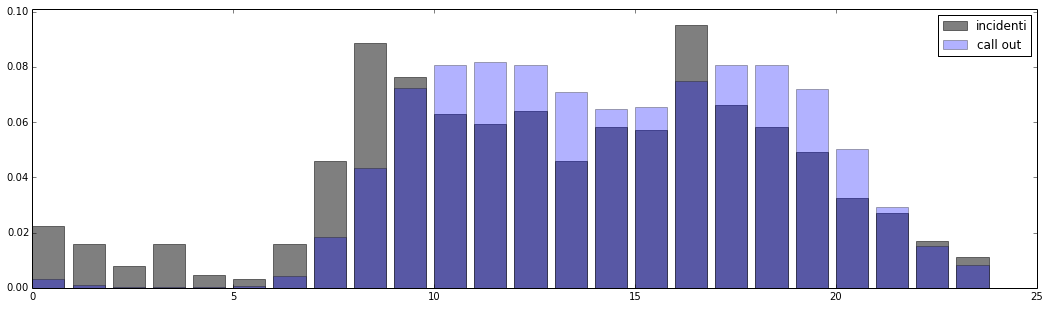

fri


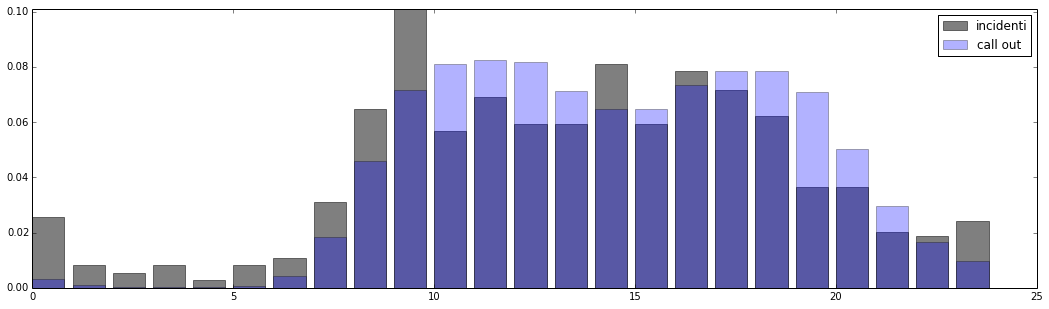

sat


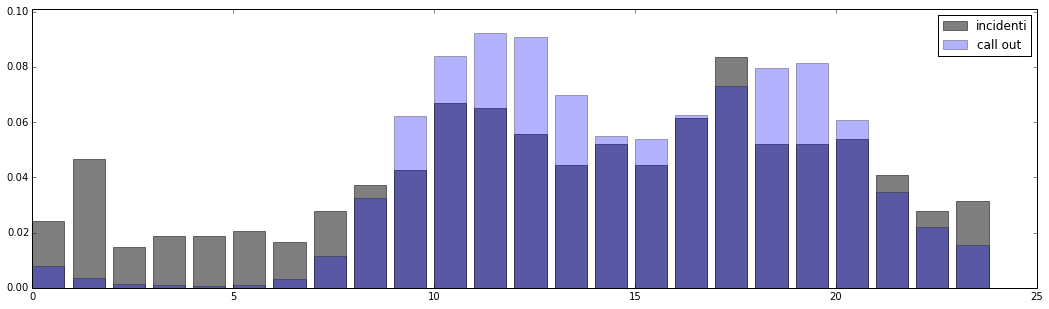

sun


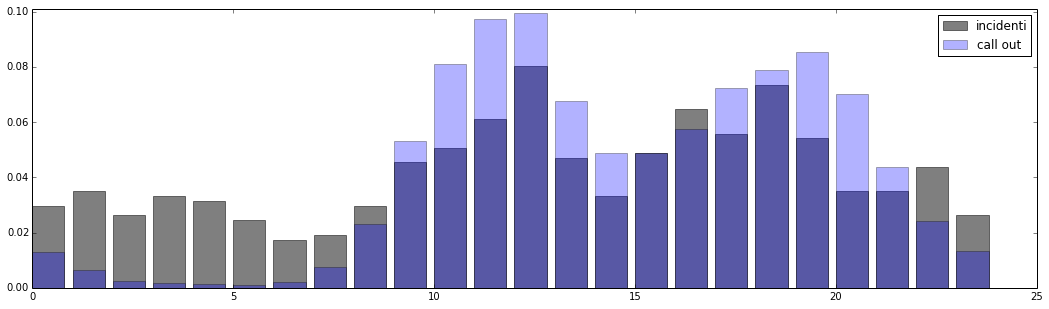

In [7]:
days=['mon','tue','wed','thu','fri','sat','sun']
for d in range(1,8):
    print(days[d-1])
    H=np.histogram(day_time_comune[day_time_comune[:,0]==d,1],normed=True,bins=list(range(25)))
    heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.hour==i and x.weekday()+1==d]) for i in range(24)])
    heights=heights/sum(heights)
    plt.bar(H[1][:-1],H[0],alpha=0.5,color='black',label='incidenti')
    plt.bar(list(range(24)),heights,alpha=0.3,label='call out')
    plt.legend(loc='upper right')
    plt.gcf().set_size_inches(18, 5)
    plt.ylim([0,.101])
    plt.show()


In [4]:
shp='/media/amassaro/external_2T/telecom_bigdata_2015/data/tim_grid/roma-grid/intersection_Roma_W_GRIDIT_NEW'
crt=shapefile.Reader(shp)
geomet=crt.shapeRecords()
ids=np.array([g.record[0] for g in geomet])

In [5]:
inProj = Proj(init='epsg:32632')
outProj = Proj(init='epsg:4326')
T=[]
for g in geomet:
    item=[]
    for c in g.shape.points:  
        x2,y2 = transform(inProj,outProj,c[0],c[1])
        item.append([x2,y2])
    T.append(item)   
T=np.array(T)

In [6]:
tree = ET.parse('/media/amassaro/external_2T/telecom_bigdata_2015/data/external_data/xml_incidenti_mar-apr_2015.xml')
root=tree.getroot()
child=list(root)[1]

In [7]:
latlong_acc=[]
I=np.zeros(len(T))

for j in child:
    if 'Latitudine' in j.attrib.keys():
        latlong_acc.append([float(j.attrib['Longitudine']),float(j.attrib['Latitudine'])])
latlong_acc=np.array(latlong_acc)

for i  in range(len(T)):
    t=T[i]
    polygon=Polygon(t)
    for p in latlong_acc:
        point=Point(p)
        if polygon.contains(point):
            I[i]+=1   

In [8]:
acc_ids=ids[I!=0]

In [14]:
db=MongoClient()
db=db['call_out_roma']
cur=db['callOut'].find({'square_id':{'$in':list(acc_ids)}})
total_calls_in={}
times=db['callOut'].distinct('time_interval')
for t in times:
    total_calls_in[t]=0
for c in cur:
    total_calls_in[c['time_interval']]+=c['n_of_calls']
total_calls_in_d={}
keys_orig=total_calls_in.keys()
keys=[datetime.fromtimestamp(t) for t in keys_orig]
for i in range(len(keys_orig)):
    total_calls_in_d[keys[i]]=total_calls_in[keys_orig[i]]
total_calls_in=total_calls_in_d

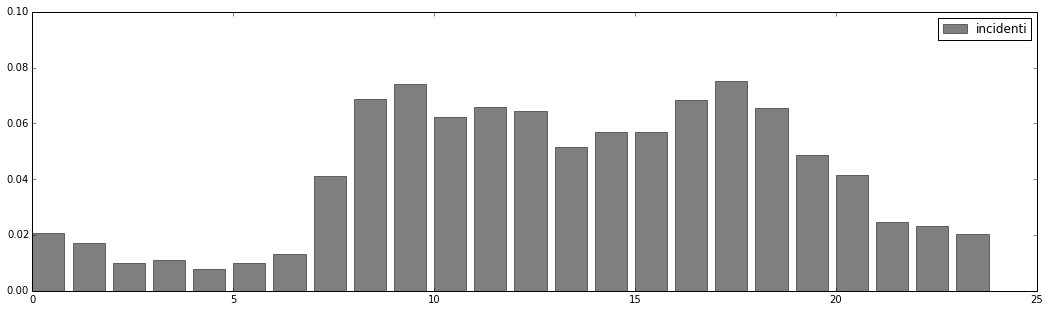

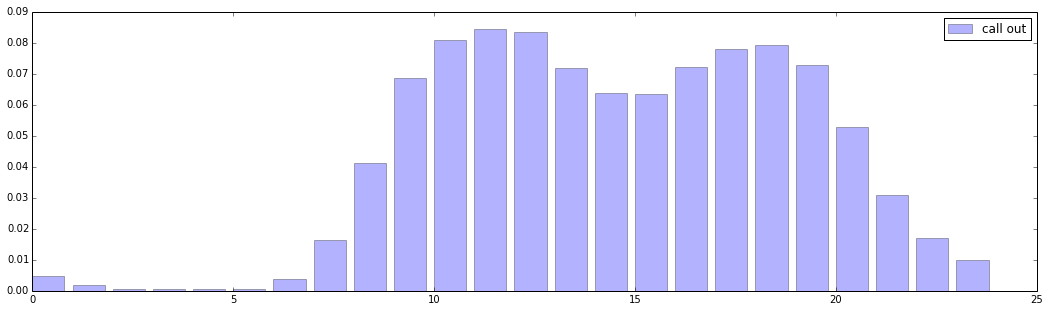

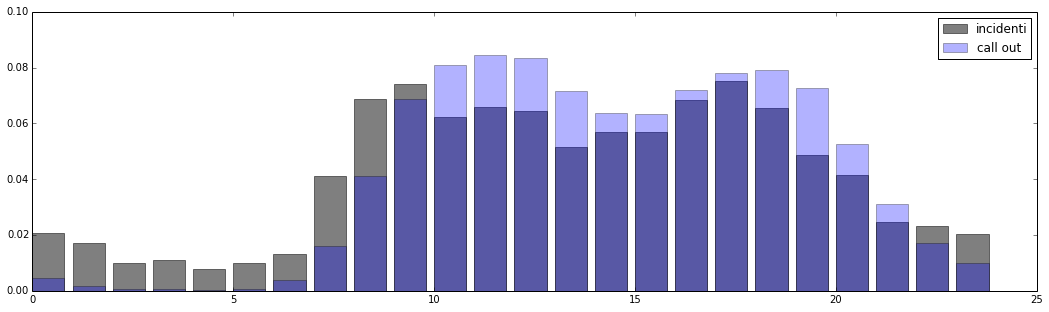

In [19]:
H=np.histogram(day_time_comune[:,1],normed=True,bins=list(range(25)))
plt.bar(H[1][:-1],H[0],alpha=0.5,color='black',label='incidenti')
plt.legend(loc='upper right')
plt.ylim([0,.1])
plt.gcf().set_size_inches(18, 5)
plt.show()

heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.hour==i]) for i in range(24)])
heights=heights/sum(heights)
plt.bar(list(range(24)),heights,alpha=0.3,label='call out')
plt.gcf().set_size_inches(18, 5)
plt.legend(loc='upper right')
plt.show()

heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.hour==i]) for i in range(24)])
heights=heights/sum(heights)
plt.bar(H[1][:-1],H[0],alpha=0.5,color='black',label='incidenti')
plt.bar(list(range(24)),heights,alpha=0.3,label='call out')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(18, 5)
plt.ylim([0,.1])
plt.show()



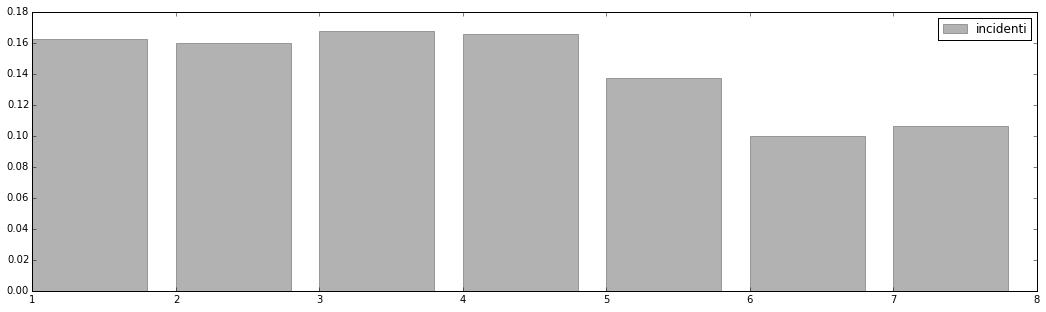

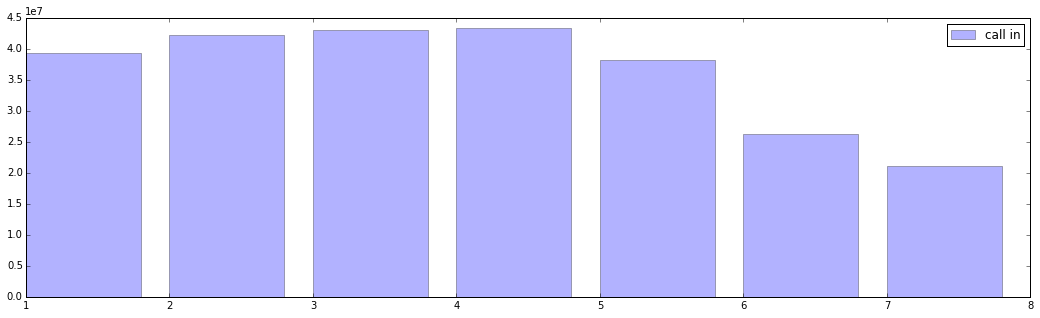

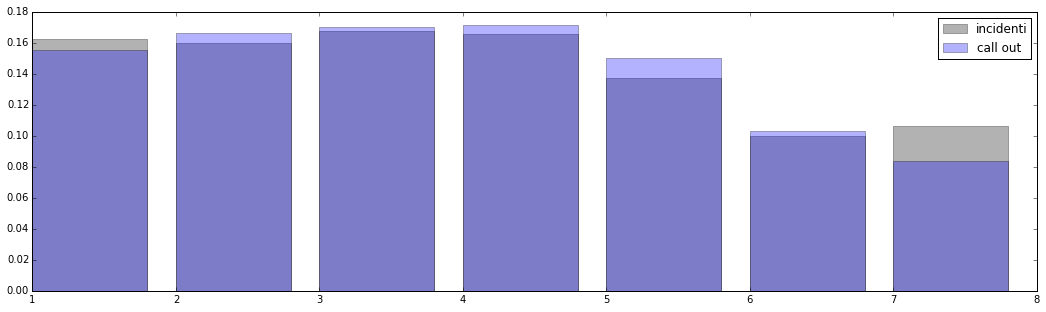

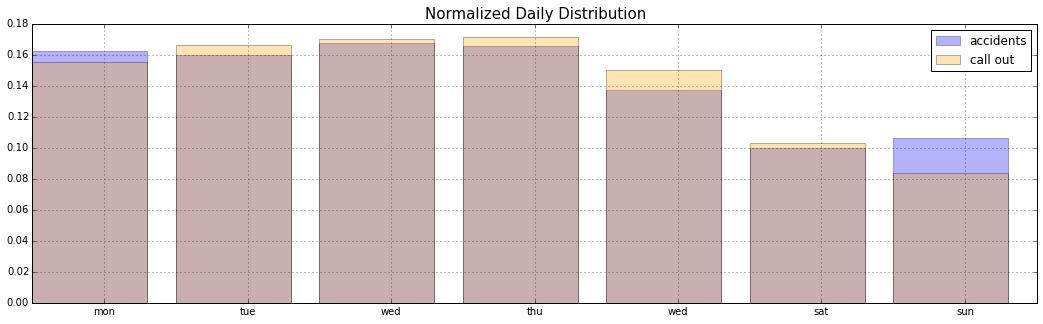

In [11]:
H=np.histogram(day_time_comune[:,0],normed=True,bins=list(range(1,9)))
plt.bar(H[1][:-1],H[0],alpha=0.3,color='black',label='incidenti')
#plt.hist(day_time_comune[:,0],normed=True,bins=list(range(1,9)),alpha=0.5,color='black',label='incidenti')
plt.legend(loc='upper right')
plt.ylim([0,.18])
plt.gcf().set_size_inches(18, 5)
plt.show()

plt.bar(list(range(1,8)),[sum([total_calls_in[x] for x in total_calls_in.keys() if x.weekday()==i]) for i in range(7)],alpha=0.3,color='blue',label='call in')
plt.gcf().set_size_inches(18, 5)
plt.legend(loc='upper right')
plt.show()

heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.weekday()==i]) for i in range(7)])
heights=heights/sum(heights)

plt.bar(H[1][:-1],H[0],alpha=0.3,color='black',label='incidenti')
plt.bar(list(range(1,8)),heights,alpha=0.3,color='blue',label='call out')
plt.gcf().set_size_inches(18, 5)
plt.legend(loc='upper right')
plt.show()

plt.bar(H[1][:-1],H[0],alpha=0.3,color='blue',label='accidents')
plt.bar(list(range(1,8)),heights,alpha=0.3,color='orange',label='call out')
plt.gcf().set_size_inches(18, 5)
plt.xticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5],['mon','tue','wed','thu','wed','sat','sun'])
plt.grid()
plt.title('Normalized Daily Distribution', size=15)
plt.legend(loc='upper right')
plt.show()

mon


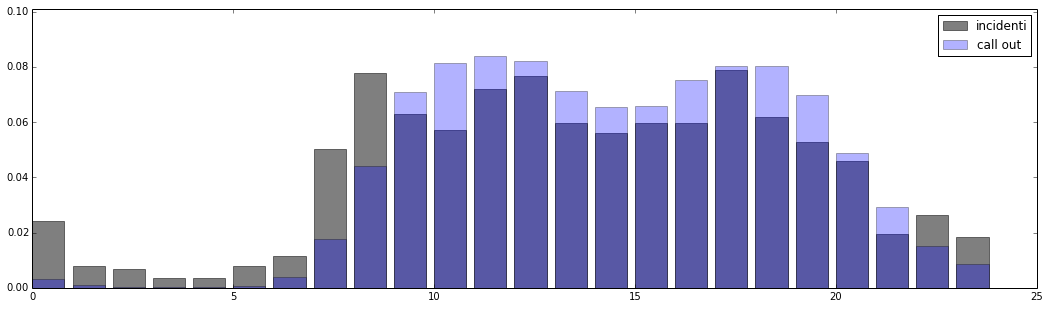

tue


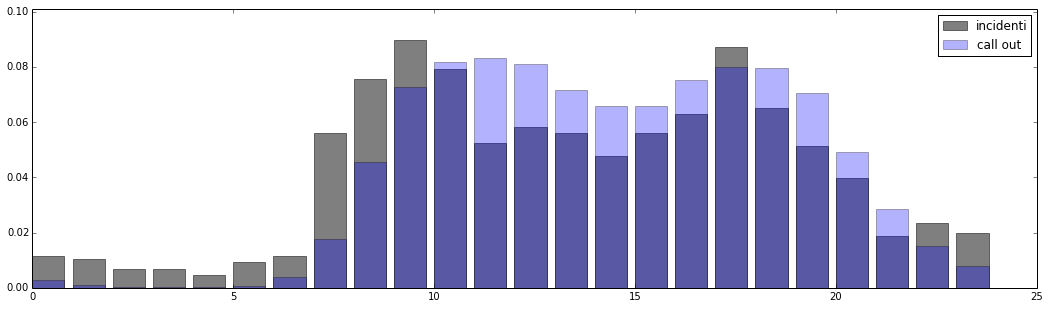

wed


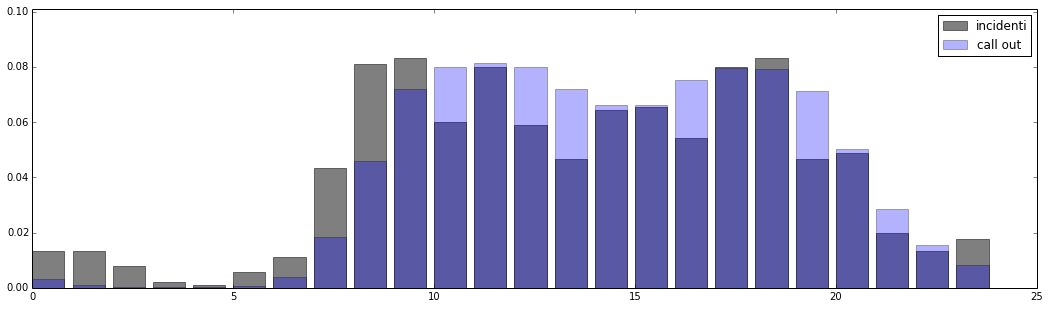

thu


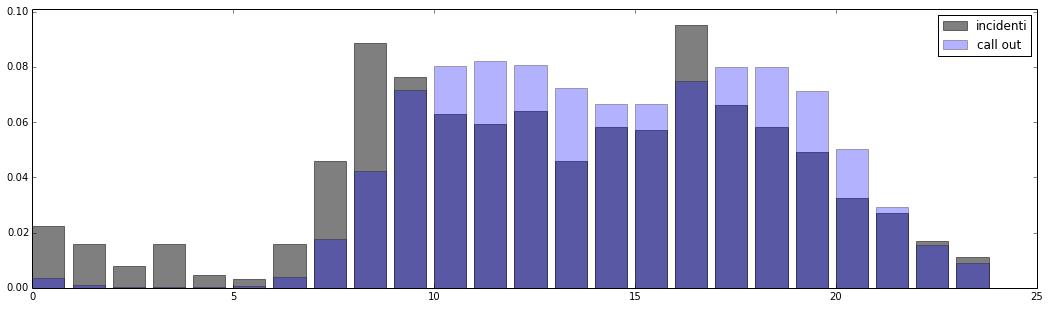

fri


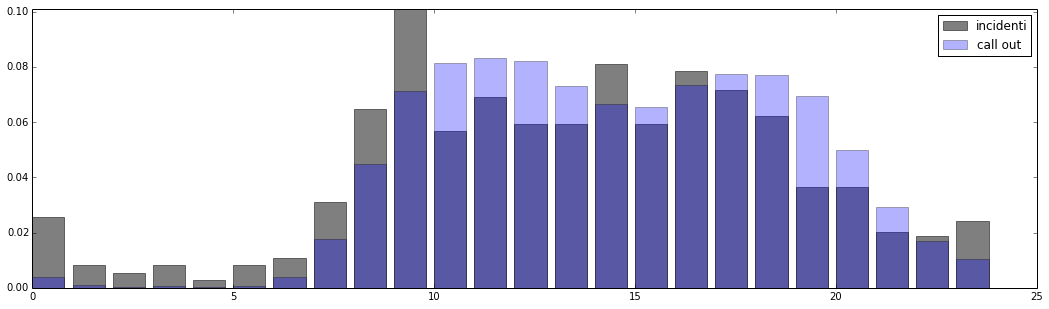

sat


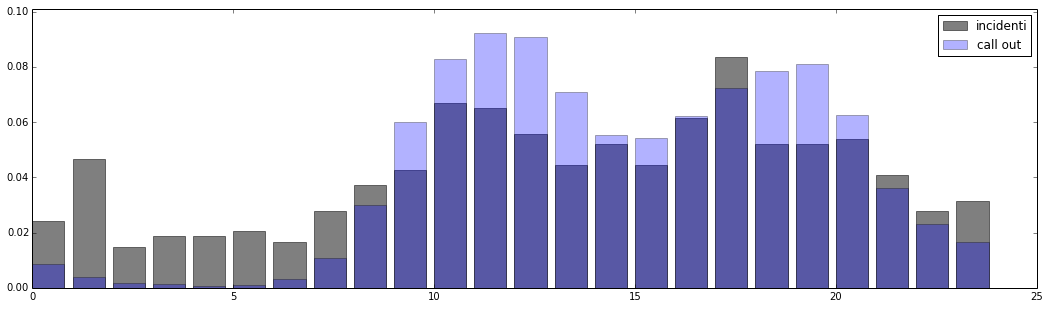

sun


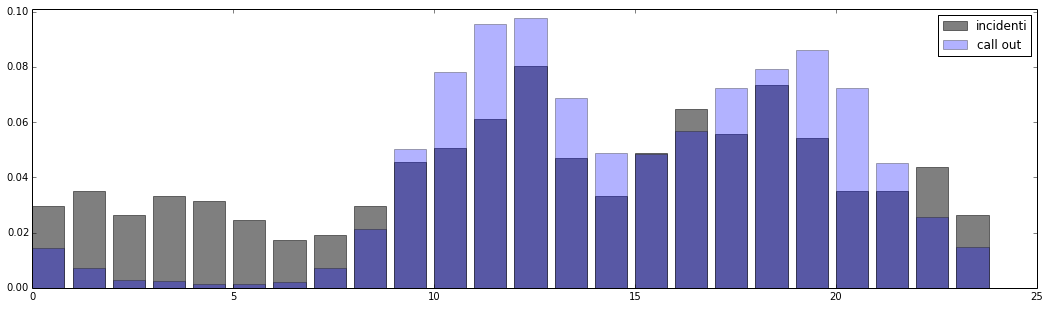

In [21]:
days=['mon','tue','wed','thu','fri','sat','sun']
for d in range(1,8):
    print(days[d-1])
    H=np.histogram(day_time_comune[day_time_comune[:,0]==d,1],normed=True,bins=list(range(25)))
    heights=np.array([sum([total_calls_in[x] for x in total_calls_in.keys() if x.hour==i and x.weekday()+1==d]) for i in range(24)])
    heights=heights/sum(heights)
    plt.bar(H[1][:-1],H[0],alpha=0.5,color='black',label='incidenti')
    plt.bar(list(range(24)),heights,alpha=0.3,label='call out')
    plt.legend(loc='upper right')
    plt.gcf().set_size_inches(18, 5)
    plt.ylim([0,.101])
    plt.show()
